In [1]:
import torch
import numpy as np
from torch.utils.data import DataLoader
import tqdm
from torch.optim import Adam
import matplotlib.pyplot as plt
import seaborn as sns
from lib.fno import FNO1d
from lib.utils import relative_l2_error
from lib.dataset import PDEDataset

In [2]:
sns.set_context("paper")
sns.set_style("whitegrid")

In [3]:
torch.manual_seed(0)
np.random.seed(0)

In [4]:
N_TRAIN = 64 # number of training samples
BATCH_SIZE = 64
DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'

In [5]:
training_data = PDEDataset("data/train_sol.npy", device=DEVICE)
# choose N_TRAIN samples randomly
val_data, train_data = torch.utils.data.random_split(training_data, [N_TRAIN, len(training_data) - N_TRAIN])

In [6]:
train_data_loader = DataLoader(train_data, batch_size=BATCH_SIZE, shuffle=True)
val_data_loader = DataLoader(val_data, batch_size=BATCH_SIZE, shuffle=True)

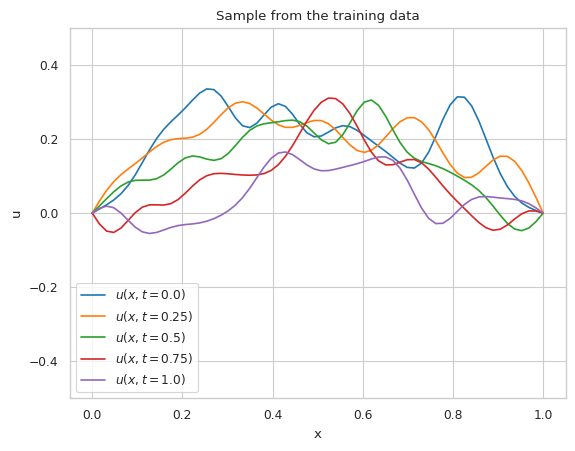

In [7]:
# plot a random sample from the training data
sample = training_data.data[np.random.randint(0, len(train_data))]
for t in range(len(sample)):
    plt.plot(
        sample[t, :, 1].cpu().numpy(),
        sample[t, :, 0].cpu().numpy(), label=f'$u(x, t={t / 4})$')

plt.ylim(-0.5, 0.5)
plt.xlabel("x")
plt.ylabel("u")
plt.title("Sample from the training data")
plt.legend()

In [8]:
learning_rate = 0.0001
epochs = 5000
step_size = 50
gamma = 0.75

In [9]:
modes = 16
width = 64
layers = 2
fno = FNO1d(modes, width, layers).to(DEVICE)  # model

In [10]:
optimizer = Adam(fno.parameters(), lr=learning_rate, weight_decay=1e-5)
# scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=step_size, gamma=gamma)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', patience=step_size)
# scheduler = torch.optim.lr_scheduler.CosineAnnealingWarmRestarts(optimizer, T_0 = step_size, eta_min=1e-6)

In [11]:
fno.train()

metrics = {
    "training_loss": [],
    "validation_loss": [],
    "lr": [],
}

progress_bar = tqdm.tqdm(range(epochs))
for epoch in progress_bar:
    train_loss = 0.0
    for input, target in train_data_loader:

        optimizer.zero_grad()
        prediction = fno(input).squeeze(-1)

        loss = relative_l2_error(prediction, target, dim=None)
        loss.backward()
        optimizer.step()

        train_loss += loss.item()

    train_loss /= len(train_data_loader)

    # Compute validation loss
    validation_relative_l2 = 0.0
    for input, target in val_data_loader:

        with torch.no_grad():
            prediction = fno(input).squeeze(-1)

        loss = torch.sum(relative_l2_error(prediction, target))
        validation_relative_l2 += loss.item()

    validation_relative_l2 /= len(val_data)

    metrics["training_loss"].append(train_loss)
    metrics["lr"].append(scheduler.get_last_lr())
    metrics["validation_loss"].append(validation_relative_l2)

    scheduler.step(validation_relative_l2)

    progress_bar.set_postfix(
        {
            "train_loss": train_loss,
            "val_loss": validation_relative_l2,
        }
    )


  0%|          | 0/5000 [00:00<?, ?it/s]

100%|██████████| 5000/5000 [00:33<00:00, 151.14it/s, train_loss=0.00876, val_loss=0.0261]


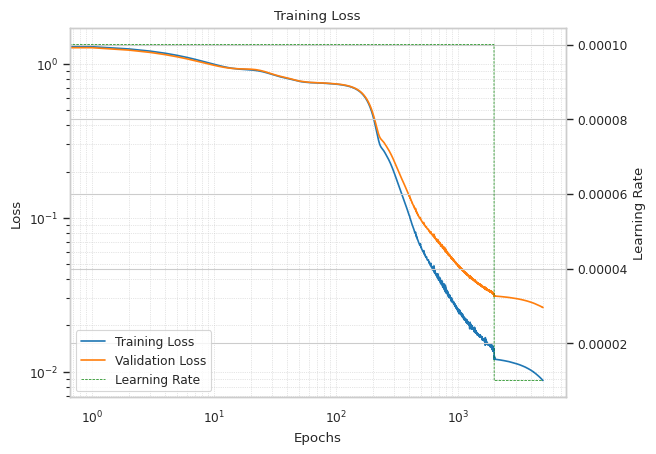

In [12]:
fig, ax1 = plt.subplots()
ax2 = ax1.twinx()

l1 = ax1.loglog(metrics["training_loss"], label="Training Loss")
l2 = ax1.loglog(metrics["validation_loss"], label="Validation Loss")
l3 = ax2.plot(metrics["lr"], label="Learning Rate", color="green", linestyle="--", linewidth=0.5)

ax1.set_xlabel("Epochs")
ax1.set_ylabel("Loss")
ax2.set_ylabel("Learning Rate")
plt.title("Training Loss")

plt.legend(l1 + l2 + l3, [l.get_label() for l in l1 + l2 + l3])
ax1.grid(True, which="both", ls=":", linewidth=0.5)
plt.show()

In [13]:
test_data = PDEDataset("data/test_sol.npy", device=DEVICE)
test_data_loader = DataLoader(test_data, batch_size=BATCH_SIZE, shuffle=True)

In [14]:
fno.eval()
progress_bar = tqdm.tqdm(test_data_loader)

with torch.no_grad():
    test_relative_l2 = 0.0
    for input, target in progress_bar:
        
        prediction = fno(input).squeeze(-1)

        loss = torch.sum(relative_l2_error(prediction, target))
        test_relative_l2 += loss.item()
    test_relative_l2 /= len(test_data)

test_relative_l2

100%|██████████| 2/2 [00:00<00:00, 448.95it/s]


0.02927772980183363

In [15]:
# save model to disk
torch.save(fno.state_dict(), "models/fno_model.pth")